<center><h1>Clustering

In [2]:
import copy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer

plt.rcParams['figure.figsize'] = [64, 32]
%matplotlib inline

In [3]:
content = pd.read_csv('content.csv')
content

,title,year,rating,imdb,rotten,service,type,original,tconst,titleType,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N
0,The Pianist,2002,18+,8.5,95.0,amazon,movie,0,tt0253474,movie,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Avengers,2012,13+,8.0,92.0,amazon,movie,0,tt0848228,movie,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3 Idiots,2009,13+,8.4,100.0,amazon,movie,0,tt1187043,movie,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,American Beauty,1999,18+,8.3,87.0,amazon,movie,0,tt0169547,movie,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Once Upon a Time in the West,1968,13+,8.5,98.0,amazon,movie,0,tt0064116,movie,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22204,Hard Knocks '17: Training Camp With The Tampa ...,2017,NaN,NaN,NaN,hbo,tv,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22205,Hijos del Carnaval,2008,NaN,NaN,NaN,hbo,tv,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22206,HBO Storybook Musicals,1987,all,NaN,NaN,hbo,tv,0,tt2738036,tvSeries,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22207,Playing for Change,2018,NaN,NaN,NaN,hbo,tv,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
tmp = content['genres'].str.split('\s*,\s*', expand=True).stack().str.get_dummies().sum(level=0)

for i in tmp.columns:
    content[i] = tmp[i]

KeyError: 'genres'

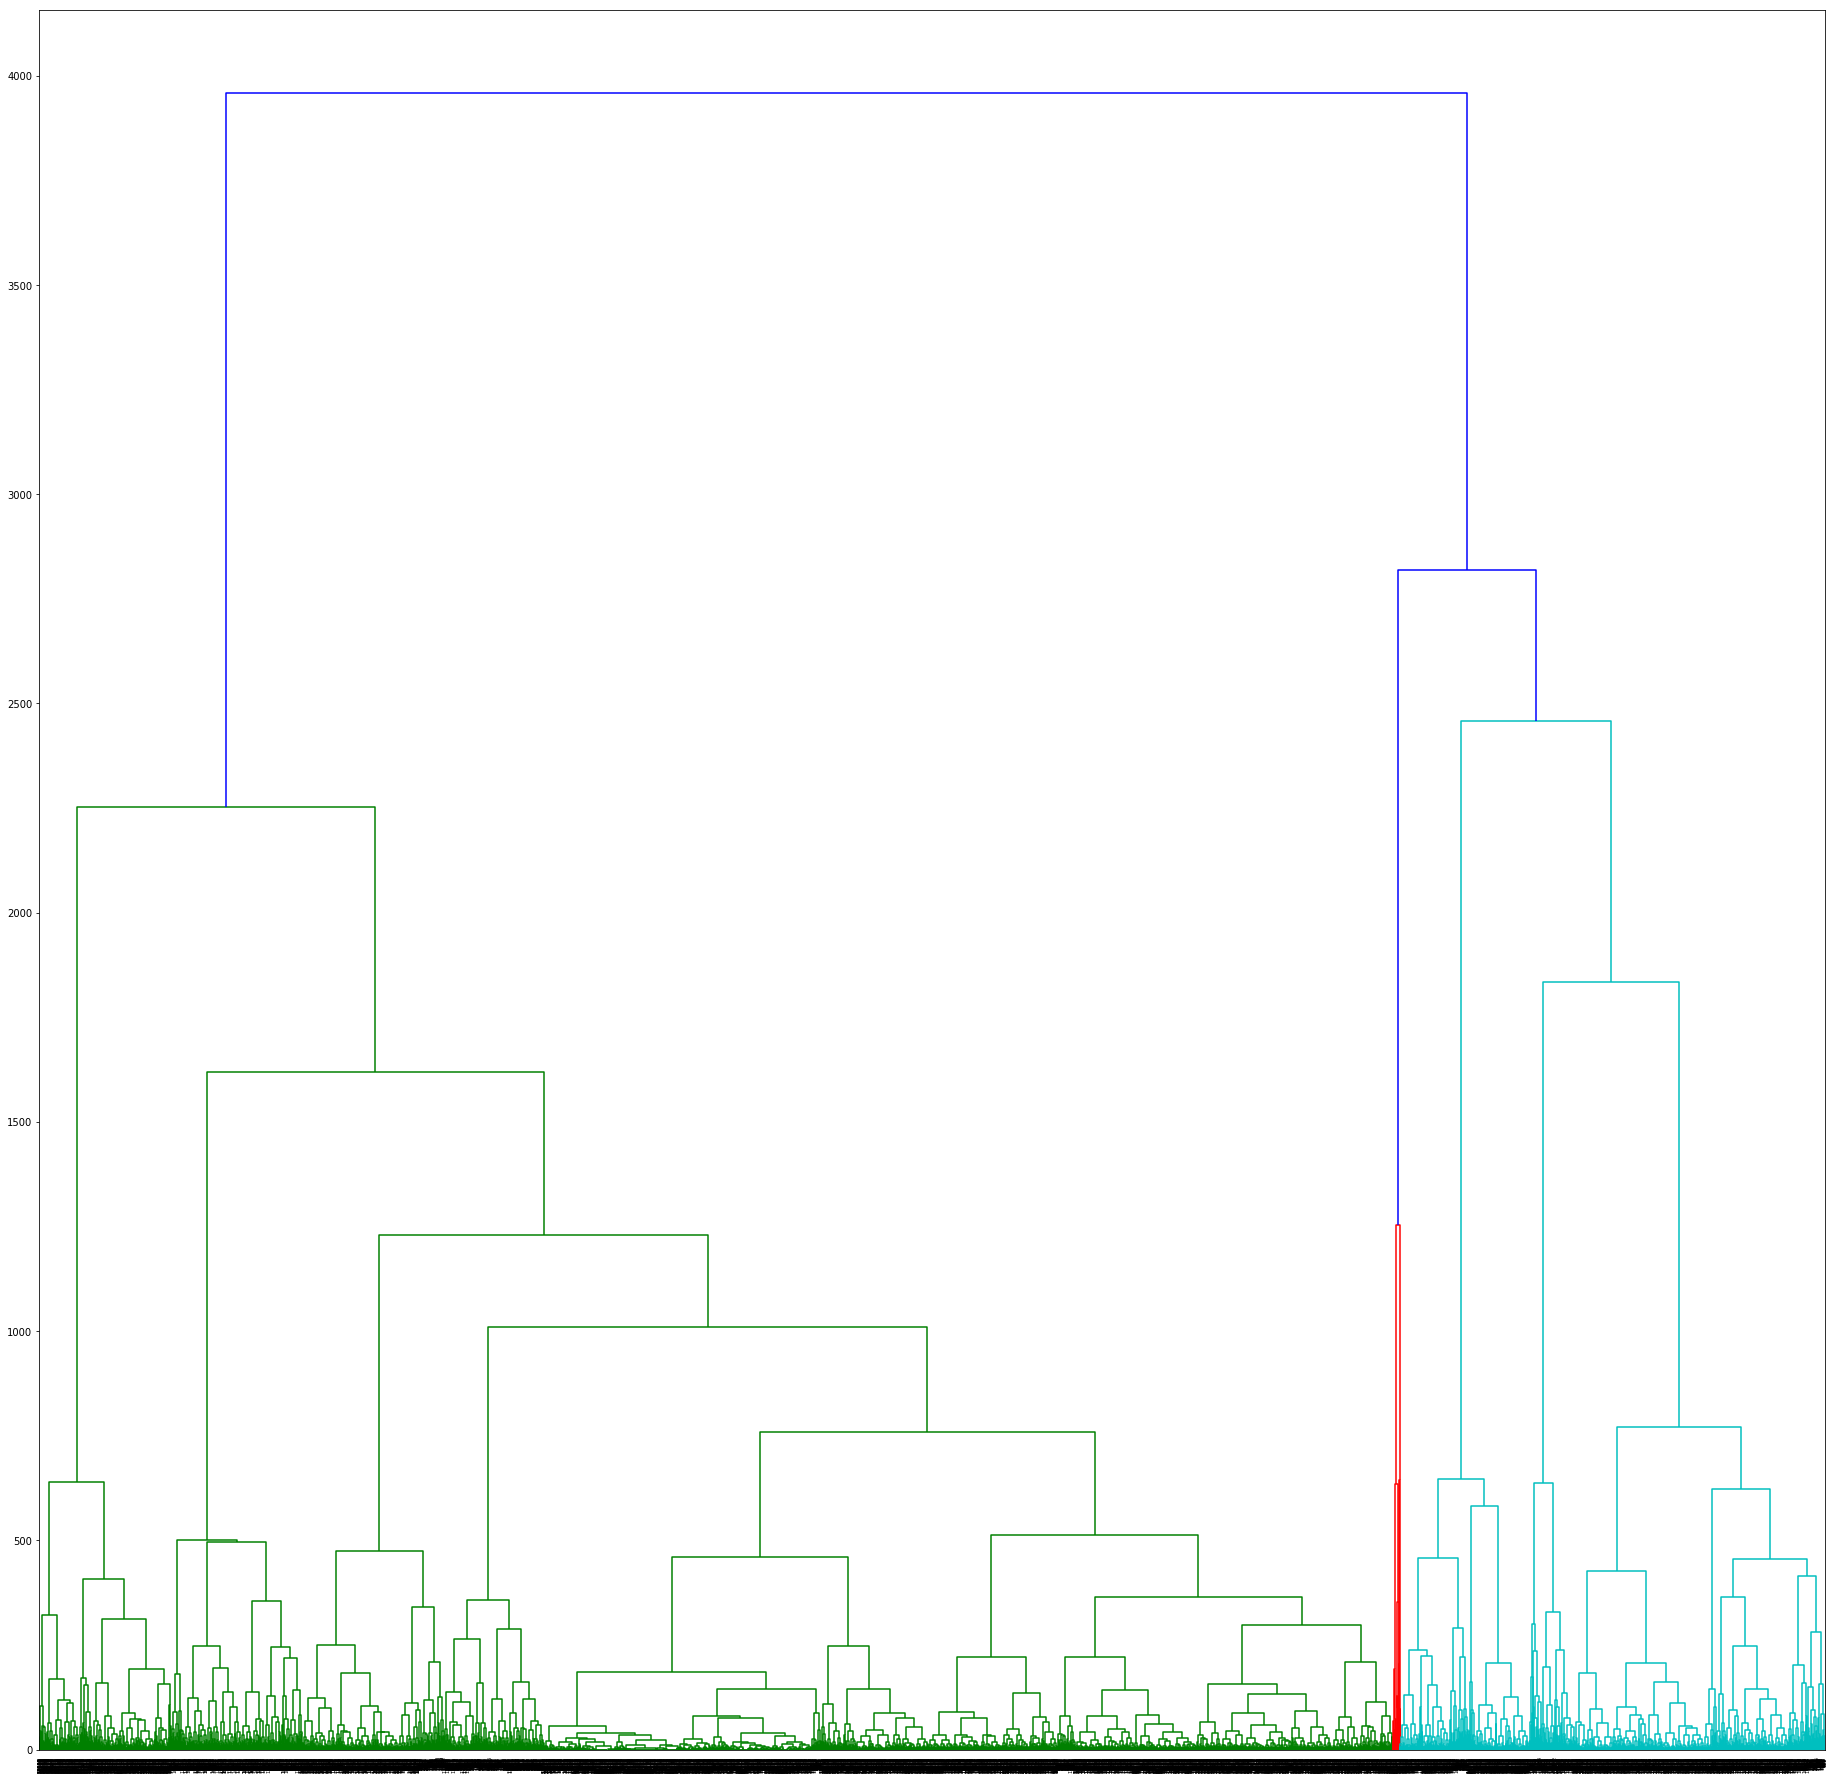

In [5]:
amazon = content[content['service']=='amazon']

amazon = amazon.drop('title', axis=1)
amazon = amazon.drop('primaryTitle', axis=1)
amazon = amazon.drop('originalTitle', axis=1)
amazon = amazon.drop('service', axis=1)
amazon = amazon.drop('tconst', axis=1)
amazon = amazon.drop(r'\N', axis=1)

amazon['rating'] = amazon['rating'].replace('all', '0+')
amazon['rating'] = amazon['rating'].str[:-1].astype(float)

amazon['endYear'] = amazon['endYear'].replace(r'\\N', np.nan, regex=True)
amazon['runtimeMinutes'] = amazon['runtimeMinutes'].replace(r'\\N', np.nan, regex=True)

amazon = pd.concat((amazon, pd.get_dummies(amazon['type'], prefix='type')), axis=1)
amazon = pd.concat((amazon, pd.get_dummies(amazon['titleType'], prefix='subtype')), axis=1)

amazon = amazon.drop('type', axis=1)
amazon = amazon.drop('titleType', axis=1)

amazon_columns = amazon.columns

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

amazon = imputer.fit_transform(amazon)

Z = linkage(amazon, 'ward')

plt.figure(figsize=(32,32))

dendrogram(Z)

plt.show()

In [6]:
cut = cut_tree(Z, n_clusters=5)
labels = list([i[0] for i in cut])

In [7]:
labeled_amazon = pd.DataFrame(amazon, columns=amazon_columns)
labeled_amazon['label'] = labels

In [24]:
for l in sorted(labeled_amazon['label'].unique()):
    display(labeled_amazon[labeled_amazon['label']==l].describe())
    labeled_amazon[labeled_amazon['label']==l].describe().to_csv('cluster'+str(l)+'.csv', index=True)

,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_tvShort,subtype_tvSpecial,subtype_video,label
count,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,...,10574.000000,10574.000000,10574.00000,10574.000000,10574.000000,10574.000000,10574.0,10574.000000,10574.000000,10574.0
mean,2011.017023,13.525182,5.779053,63.355257,0.011821,0.000919,2006.911831,2005.318039,93.440336,0.149852,...,0.884812,0.115188,0.57405,0.003688,0.040004,0.023832,0.0,0.000284,0.033857,0.0
std,6.392154,3.518125,1.398278,14.458127,0.108087,0.025718,7.557260,0.682604,11.523870,0.287208,...,0.319264,0.319264,0.49451,0.060622,0.195977,0.152533,0.0,0.016842,0.180869,0.0
min,1971.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1971.000000,1997.000000,63.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,2008.000000,13.246665,4.900000,64.177952,0.000000,0.000000,1999.419861,2005.272072,90.000000,0.000000,...,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
50%,2013.000000,13.246665,5.906005,64.177952,0.000000,0.000000,2008.000000,2005.272072,91.136682,0.000000,...,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
75%,2016.000000,13.246665,6.800000,64.177952,0.000000,0.000793,2014.000000,2005.272072,95.000000,0.166094,...,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
max,2020.000000,18.000000,9.300000,100.000000,1.000000,1.000000,2020.000000,2019.000000,160.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0


,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_tvShort,subtype_tvSpecial,subtype_video,label
count,2555.00000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,...,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.0,2555.0,2555.000000,2555.0
mean,1980.05910,13.063422,5.993469,65.686654,0.006262,0.000990,1987.482375,2005.171102,104.650076,0.251644,...,0.952642,0.047358,0.601174,0.010176,0.096673,0.009393,0.0,0.0,0.021135,1.0
std,16.63793,4.510731,1.259838,8.067755,0.078902,0.027969,14.308143,1.667893,27.716221,0.390085,...,0.212445,0.212445,0.489753,0.100382,0.295570,0.096482,0.0,0.0,0.143863,0.0
min,1901.00000,0.000000,1.900000,17.000000,0.000000,0.000000,1915.000000,1976.000000,38.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0
25%,1972.00000,13.246665,5.200000,64.177952,0.000000,0.000000,1976.000000,2005.272072,91.136682,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0
50%,1980.00000,13.246665,6.100000,64.177952,0.000000,0.000000,1989.000000,2005.272072,92.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0
75%,1990.00000,18.000000,6.900000,64.177952,0.000000,0.000793,1999.419861,2005.272072,106.000000,0.166094,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0
max,2019.00000,18.000000,9.500000,100.000000,1.000000,1.000000,2019.000000,2018.000000,261.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.0


,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_tvShort,subtype_tvSpecial,subtype_video,label
count,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.0,1122.000000,1122.000000,1122.000000,1122.000000,...,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.0,1122.0,1122.0,1122.0
mean,1946.167558,12.233652,5.873005,65.845663,0.003565,0.0,1946.167558,2003.484547,72.816521,0.202317,...,0.947415,0.052585,0.937611,0.000891,0.009804,0.051693,0.0,0.0,0.0,2.0
std,10.960821,3.336473,1.050276,9.806984,0.059628,0.0,10.960821,8.459515,17.190520,0.401907,...,0.223302,0.223302,0.241968,0.029854,0.098572,0.221506,0.0,0.0,0.0,0.0
min,1915.000000,0.000000,1.900000,13.000000,0.000000,0.0,1915.000000,1948.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
25%,1937.000000,13.246665,5.300000,64.177952,0.000000,0.0,1937.000000,2005.272072,63.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
50%,1945.000000,13.246665,5.906005,64.177952,0.000000,0.0,1945.000000,2005.272072,72.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
75%,1955.000000,13.246665,6.500000,64.177952,0.000000,0.0,1955.000000,2005.272072,83.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
max,1978.000000,18.000000,8.800000,100.000000,1.000000,0.0,1978.000000,2005.272072,148.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,2.0


,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_tvShort,subtype_tvSpecial,subtype_video,label
count,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.0,1137.000000,1137.000000,1137.000000,1137.000000,...,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.0
mean,2008.883905,12.079682,6.846347,66.531777,0.071240,0.0,2008.883905,2006.787433,43.972735,0.090589,...,0.379947,0.620053,0.197889,0.047493,0.094107,0.569041,0.002639,0.000880,0.087951,3.0
std,8.287563,5.012542,1.247176,9.521232,0.257339,0.0,8.287563,5.043525,15.868578,0.287150,...,0.485587,0.485587,0.398583,0.212785,0.292106,0.495428,0.051321,0.029656,0.283348,0.0
min,1973.000000,0.000000,0.000000,15.000000,0.000000,0.0,1973.000000,1980.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,2005.000000,13.246665,5.906005,64.177952,0.000000,0.0,2005.000000,2005.272072,30.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
50%,2011.000000,13.246665,7.000000,64.177952,0.000000,0.0,2011.000000,2005.272072,48.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.0
75%,2015.000000,16.000000,7.800000,64.177952,0.000000,0.0,2015.000000,2005.272072,60.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.0
max,2020.000000,18.000000,9.400000,100.000000,1.000000,0.0,2020.000000,2020.000000,70.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0


,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_tvShort,subtype_tvSpecial,subtype_video,label
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.0,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.0,58.000000,58.0,58.0,58.000000,58.0
mean,2004.051724,13.015631,7.402138,69.298207,0.051724,0.0,2004.051724,2006.212861,354.844828,0.137931,...,0.103448,0.896552,0.086207,0.655172,0.0,0.241379,0.0,0.0,0.017241,4.0
std,14.864797,4.510591,1.177254,14.284810,0.223404,0.0,14.864797,7.522689,151.155642,0.347839,...,0.307203,0.307203,0.283121,0.479463,0.0,0.431657,0.0,0.0,0.131306,0.0
min,1936.000000,0.000000,4.600000,14.000000,0.000000,0.0,1936.000000,1980.000000,225.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,4.0
25%,1998.250000,13.246665,6.875000,64.177952,0.000000,0.0,1998.250000,2005.272072,258.750000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,4.0
50%,2007.500000,13.246665,7.650000,64.177952,0.000000,0.0,2007.500000,2005.272072,316.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,4.0
75%,2014.000000,16.000000,8.175000,64.177952,0.000000,0.0,2014.000000,2010.750000,371.250000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,4.0
max,2020.000000,18.000000,9.500000,100.000000,1.000000,0.0,2020.000000,2020.000000,1140.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,4.0


In [19]:
labeled_amazon['title'] = list(content[content['service']=='amazon']['title'])

In [25]:
display(labeled_amazon[labeled_amazon['label']==0].sort_values('imdb', ascending=False))

,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_tvShort,subtype_tvSpecial,subtype_video,label,title
3417,2015.0,13.246665,9.3,64.177952,0.0,0.000000,2015.000000,2005.272072,68.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"Down, But Not Out!"
914,2011.0,13.246665,9.3,64.177952,0.0,0.000000,2011.000000,2005.272072,90.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,Love on a Leash
3987,2011.0,13.246665,9.3,64.177952,0.0,0.000793,1999.419861,2005.272072,91.136682,0.166094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Bounty
14216,2016.0,13.246665,9.2,64.177952,0.0,0.000793,1999.419861,2005.272072,91.136682,0.166094,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Owlegories
3230,2014.0,13.246665,9.2,60.000000,0.0,0.000793,1999.419861,2005.272072,91.136682,0.166094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Men Of The Cloth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12438,2016.0,13.246665,1.3,64.177952,0.0,0.000793,1999.419861,2005.272072,91.136682,0.166094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Shark Exorcist
12389,2011.0,0.000000,1.0,64.177952,0.0,0.000000,2011.000000,2005.272072,65.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,Justin Bieber: Rise to Fame
12579,2013.0,13.246665,1.0,64.177952,0.0,0.000793,1999.419861,2005.272072,91.136682,0.166094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Justin Bieber: Always Believing
7412,2018.0,13.246665,0.0,64.177952,0.0,0.000793,1999.419861,2005.272072,91.136682,0.166094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Capture


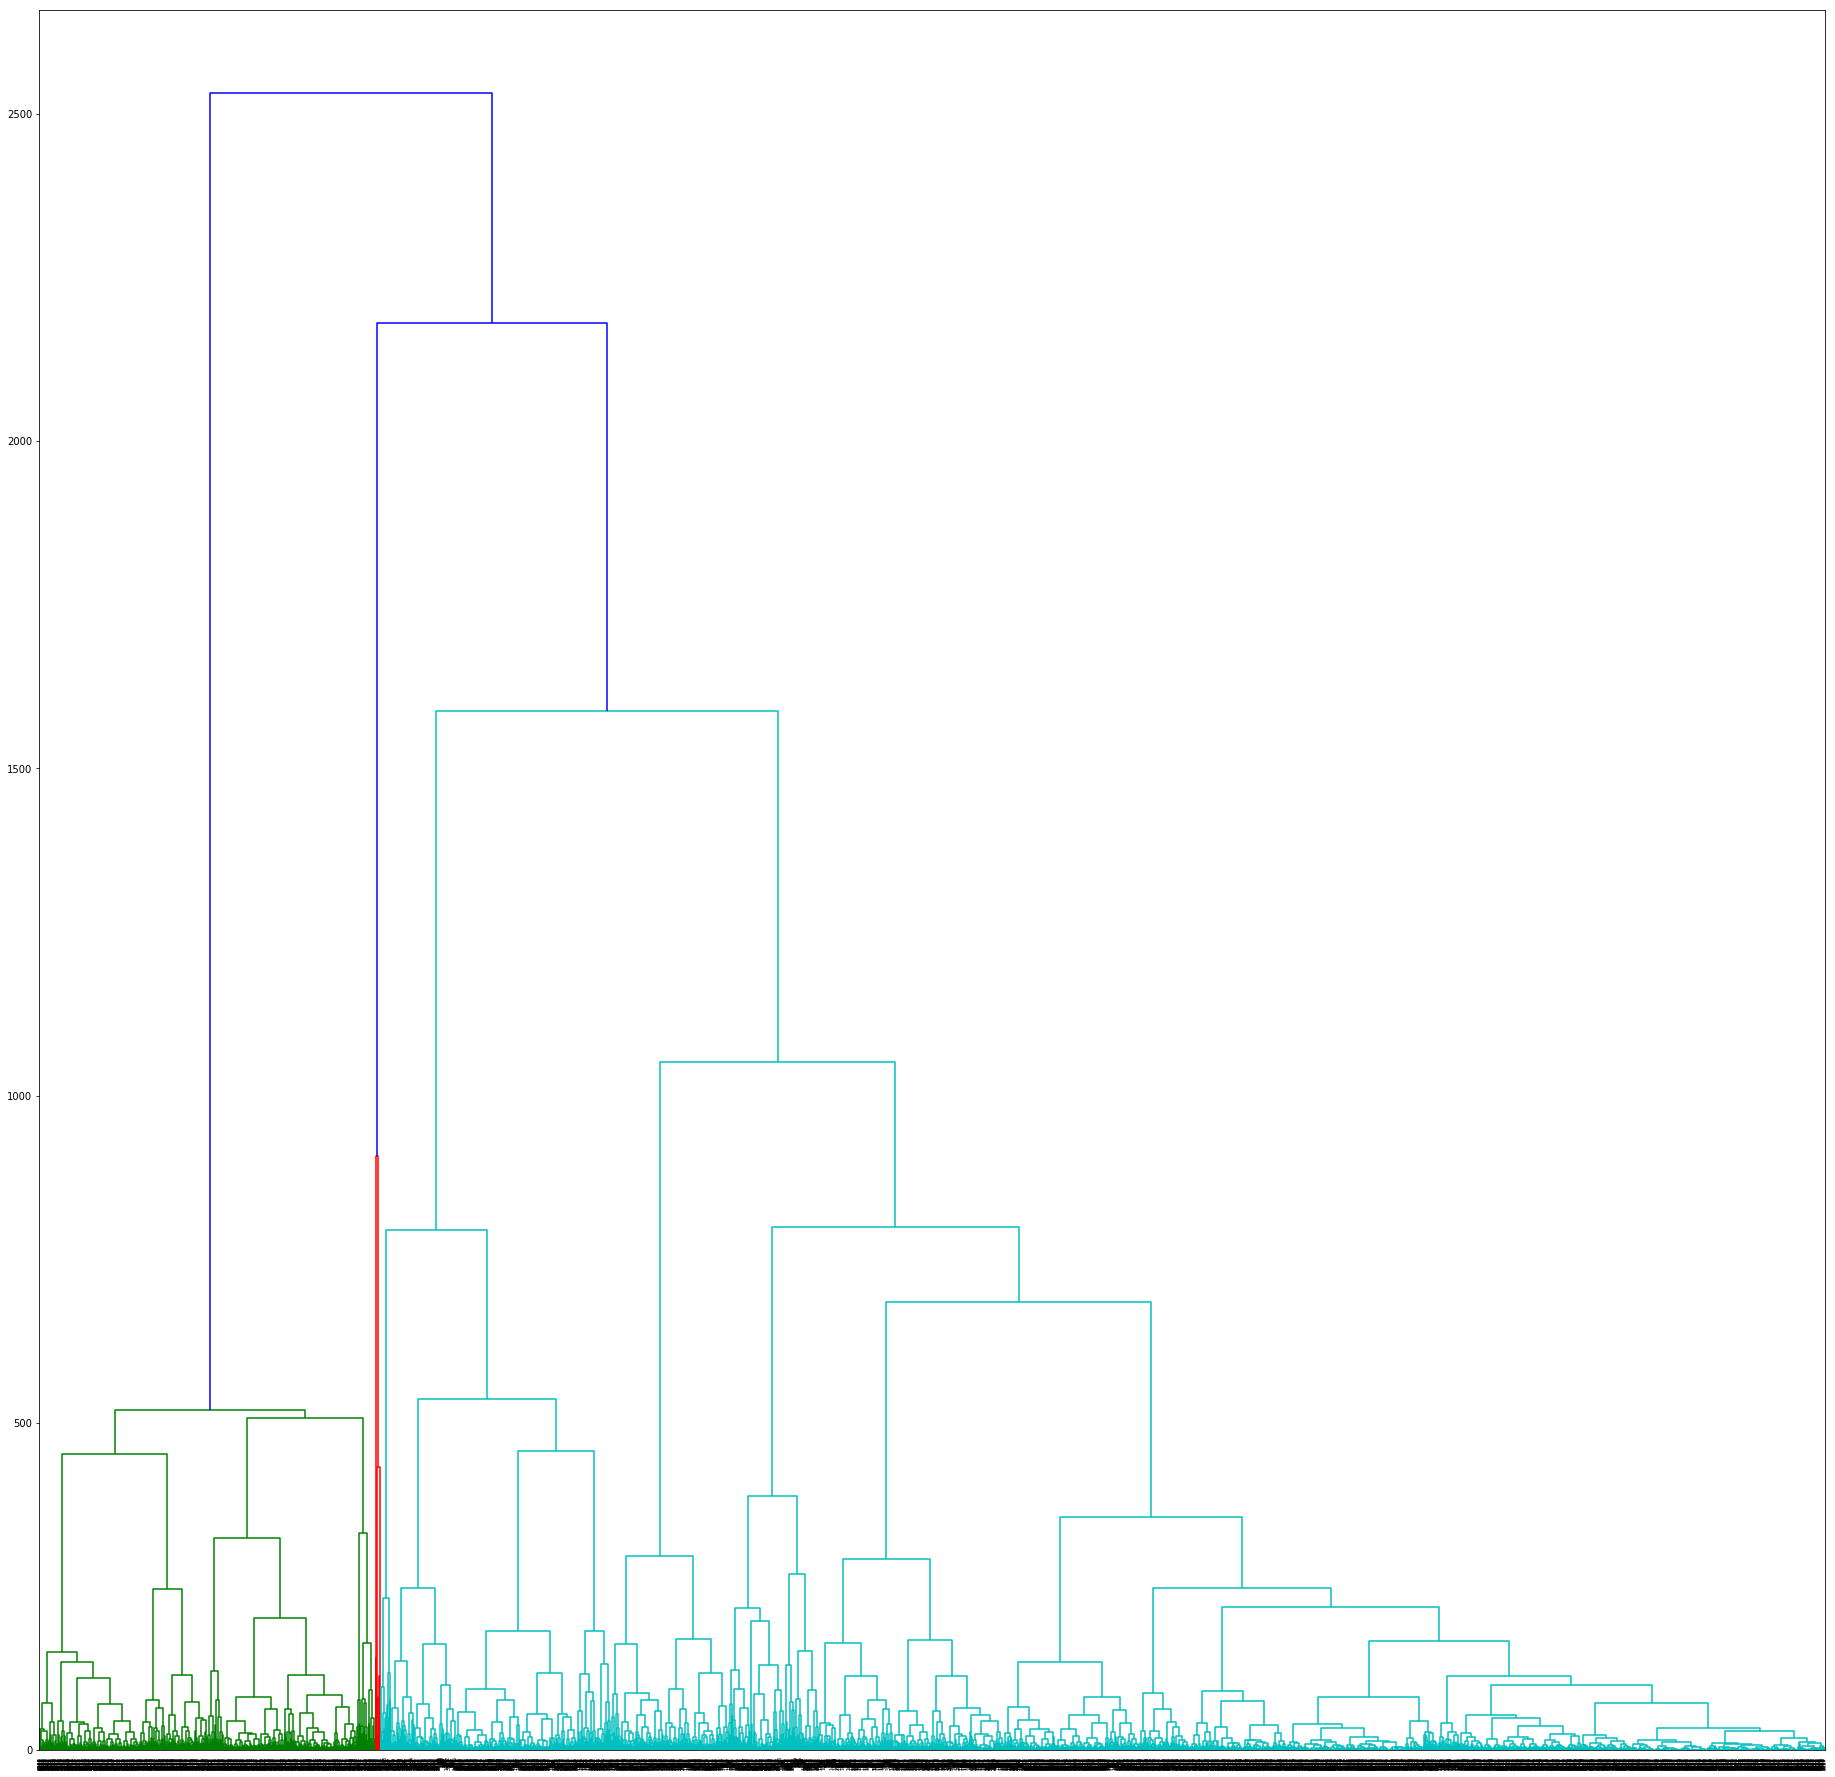

In [26]:
netflix = content[content['service']=='netflix']

netflix = netflix.drop('title', axis=1)
netflix = netflix.drop('primaryTitle', axis=1)
netflix = netflix.drop('originalTitle', axis=1)
netflix = netflix.drop('service', axis=1)
netflix = netflix.drop('tconst', axis=1)
netflix = netflix.drop(r'\N', axis=1)

netflix['rating'] = netflix['rating'].replace('all', '0+')
netflix['rating'] = netflix['rating'].str[:-1].astype(float)

netflix['endYear'] = netflix['endYear'].replace(r'\\N', np.nan, regex=True)
netflix['runtimeMinutes'] = netflix['runtimeMinutes'].replace(r'\\N', np.nan, regex=True)

netflix = pd.concat((netflix, pd.get_dummies(netflix['type'], prefix='type')), axis=1)
netflix = pd.concat((netflix, pd.get_dummies(netflix['titleType'], prefix='subtype')), axis=1)

netflix = netflix.drop('type', axis=1)
netflix = netflix.drop('titleType', axis=1)

netflix_columns = netflix.columns

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

netflix = imputer.fit_transform(netflix)

Z = linkage(netflix, 'ward')

plt.figure(figsize=(32,32))

dendrogram(Z)

plt.show()

In [27]:
cut = cut_tree(Z, n_clusters=4)
labels = list([i[0] for i in cut])

In [28]:
labeled_netflix = pd.DataFrame(netflix, columns=netflix_columns)
labeled_netflix['label'] = labels

In [30]:
for l in sorted(labeled_netflix['label'].unique()):
    display(labeled_netflix[labeled_netflix['label']==l].describe())
    labeled_netflix[labeled_netflix['label']==l].describe().to_csv('cluster'+str(l)+'.csv', index=True)

,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,War,Western,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_video,label
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,...,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.0
mean,2012.439607,12.707127,6.505255,66.538317,0.068820,0.001404,2012.439607,2014.034635,138.901685,0.242978,...,0.016854,0.004213,0.953652,0.046348,0.945225,0.035112,0.004213,0.011236,0.004213,0.0
std,6.365718,3.882555,1.199443,16.017819,0.253326,0.037477,6.365718,1.342347,27.923371,0.429183,...,0.128815,0.064820,0.210386,0.210386,0.227701,0.184193,0.064820,0.105477,0.064820,0.0
min,1964.000000,0.000000,1.700000,6.000000,0.000000,0.000000,1964.000000,1986.000000,104.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,2009.000000,12.765914,5.800000,69.232134,0.000000,0.000000,2009.000000,2013.998058,121.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2014.000000,12.765914,6.600000,69.232134,0.000000,0.000000,2014.000000,2013.998058,131.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2017.000000,13.000000,7.325000,69.232134,0.000000,0.000000,2017.000000,2013.998058,149.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,2020.000000,18.000000,9.100000,100.000000,1.000000,1.000000,2020.000000,2020.000000,312.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,War,Western,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_video,label
count,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,...,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.0
mean,2013.203733,12.811682,6.405908,68.956303,0.111733,0.000105,2012.792380,2014.016246,93.075718,0.152090,...,0.010425,0.003707,0.774400,0.225600,0.454933,0.012800,0.017867,0.088267,0.010933,1.0
std,8.844351,4.124486,1.152290,15.606840,0.315080,0.000125,6.916096,0.903008,9.901597,0.269097,...,0.074491,0.046110,0.418033,0.418033,0.498031,0.112426,0.132484,0.283720,0.104003,0.0
min,1914.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1959.000000,1972.000000,64.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2013.000000,12.765914,5.700000,69.232134,0.000000,0.000000,2012.808236,2013.998058,90.137795,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,2016.000000,12.765914,6.570908,69.232134,0.000000,0.000000,2012.808236,2013.998058,90.137795,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,2018.000000,13.000000,7.200000,69.232134,0.000000,0.000253,2017.000000,2013.998058,95.000000,0.162708,...,0.011622,0.003790,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,2020.000000,18.000000,9.300000,100.000000,1.000000,0.000253,2020.000000,2020.000000,184.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,War,Western,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_video,label
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.0,1038.000000,1038.000000,1038.000000,1038.000000,...,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.0
mean,2013.124277,12.636995,7.187341,71.941691,0.329480,0.0,2013.124277,2013.926504,40.167630,0.145472,...,0.010597,0.003854,0.073218,0.926782,0.030829,0.049133,0.021195,0.877649,0.021195,2.0
std,10.057835,5.354428,1.084817,13.005697,0.470251,0.0,10.057835,4.475089,15.478633,0.352746,...,0.102446,0.061987,0.260619,0.260619,0.172936,0.216250,0.144102,0.327848,0.144102,0.0
min,1920.000000,0.000000,1.800000,6.000000,0.000000,0.0,1920.000000,1966.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,2012.000000,7.000000,6.578181,69.232134,0.000000,0.0,2012.000000,2013.998058,27.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.0
50%,2016.000000,12.765914,7.400000,69.232134,0.000000,0.0,2016.000000,2013.998058,42.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.0
75%,2018.000000,16.000000,8.000000,69.232134,1.000000,0.0,2018.000000,2014.000000,54.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.0
max,2020.000000,18.000000,9.500000,100.000000,1.000000,0.0,2020.000000,2020.000000,95.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0


,year,rating,imdb,rotten,original,isAdult,startYear,endYear,runtimeMinutes,Action,...,War,Western,type_movie,type_tv,subtype_movie,subtype_tvMiniSeries,subtype_tvMovie,subtype_tvSeries,subtype_video,label
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.0,15.0,15.0,15.0,15.000000,15.0,15.000000,15.0,15.0
mean,2012.400000,13.035455,8.280000,78.554756,0.333333,0.0,2012.400000,2012.666408,498.933333,0.200000,...,0.133333,0.0,0.0,1.0,0.0,0.600000,0.0,0.400000,0.0,3.0
std,7.771744,6.475728,0.730166,13.716878,0.487950,0.0,7.771744,7.631340,193.150003,0.414039,...,0.351866,0.0,0.0,0.0,0.0,0.507093,0.0,0.507093,0.0,0.0
min,1995.000000,0.000000,7.000000,69.232134,0.000000,0.0,1995.000000,1996.000000,354.000000,0.000000,...,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,3.0
25%,2011.000000,9.882957,7.850000,69.232134,0.000000,0.0,2011.000000,2012.000000,369.000000,0.000000,...,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,3.0
50%,2016.000000,16.000000,8.300000,69.232134,0.000000,0.0,2016.000000,2014.000000,403.000000,0.000000,...,0.000000,0.0,0.0,1.0,0.0,1.000000,0.0,0.000000,0.0,3.0
75%,2018.000000,18.000000,8.750000,95.000000,1.000000,0.0,2018.000000,2018.000000,540.000000,0.000000,...,0.000000,0.0,0.0,1.0,0.0,1.000000,0.0,1.000000,0.0,3.0
max,2019.000000,18.000000,9.400000,100.000000,1.000000,0.0,2019.000000,2019.000000,990.000000,1.000000,...,1.000000,0.0,0.0,1.0,0.0,1.000000,0.0,1.000000,0.0,3.0


In [31]:
tmp = cp.copy(content[content['service']=='netflix'].reset_index())
tmp['label'] = labeled_netflix['label']

In [32]:
tmp[tmp['label']==1]

,index,title,year,rating,imdb,rotten,service,type,original,tconst,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N,label
1,15447,The Shawshank Redemption,1994,18+,9.3,90.0,netflix,movie,0,tt0111161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,15452,GoodFellas,1990,18+,8.7,96.0,netflix,movie,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,15453,City of God,2002,18+,8.6,91.0,netflix,movie,0,tt0317248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,15455,Raiders of the Lost Ark,1981,7+,8.4,95.0,netflix,movie,0,tt0082971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10,15456,Spider-Man: Into the Spider-Verse,2018,7+,8.4,97.0,netflix,movie,0,tt4633694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5510,20956,Timeless Seasons,2014,NaN,NaN,NaN,netflix,tv,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5511,20957,Road to Victory,2001,NaN,NaN,NaN,netflix,tv,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5512,20958,Sports Adventures,2000,NaN,NaN,NaN,netflix,tv,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5513,20959,High Risk,2011,NaN,NaN,NaN,netflix,tv,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
